# <font style='color: firebrick; text-align:center; display:block'> Climate Change Belief Analysis </font>

By:
1. Patrick Onduto

## <font color='goldenrod'>Table of Contents</font>
[TOC]


## <font color='goldenrod'>1. Introduction</font>

### 1.1. Problem Description
Today, many companies are built around lessening one’s environmental impact or carbon footprint. They are offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. A majority of these companies would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, we are creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution will give companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### 1.2. Data Description
The data used to build the Machine models was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.
The dataset contains 43943 aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018 with each tweet is labelled as one of the following classes:

**Class Description**
 
- 2 *``Moderate Belief``*: the tweet links to factual news about climate change
- 1 *``High Belief``*: the tweet supports the belief of man-made climate change
- 0 *``Neutral``*: the tweet neither supports nor refutes the belief of man-made climate change
- -1 *``Low Belief``*: the tweet does not believe in man-made climate change

**Variable definitions**
- **sentiment**: Sentiment of tweet
- **message**: Tweet body
- **tweetid**: Twitter unique id

For more on the data description [view source here](https://www.kaggle.com/competitions/edsa-climate-change-belief-analysis-2022/data)

## <font color='goldenrod'>2. Importing Packages</font>

Let's load python package that will be use to load the datasets, clean and format it, analysis and visualize it, and build, evaluate and draw the Machine Learning models

In [37]:
import warnings # to filter out warnings in the jupyter notebook
warnings.filterwarnings('ignore') # we will ignore all warning and not show them

import re # for creating regex expressions                               
import string # for manipulating strings

# Imports to load, explore, wrangle and visualize
import numpy as np # for data manipulation
import pandas as pd # for loading and data manipulation
import matplotlib.pyplot as plt # for drawing visualizations
import seaborn as sns # for drawing visualizations
import nltk

%matplotlib inline

# Imports for data preprocessing
from nltk.corpus import stopwords # for generatig english stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer # for word stem/lemma production 
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer # for tokenizing text to words
from sklearn.utils import resample # for resampling our dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # for vectorizing and transforming the data
from sklearn.model_selection import train_test_split # for spliting data to training and testing sets

# Imports for model building
from sklearn.linear_model import LogisticRegression # for making a Logistic Regression classifier
from sklearn.svm import SVC  # for making a Support Vector Machine classifier
from sklearn.naive_bayes import MultinomialNB # for making a Naive Bayes classifier
from sklearn.ensemble import RandomForestClassifier # for making a Random Forest classifier
from sklearn.neighbors import KNeighborsClassifier  # for making a K Neighbors classifier
from sklearn.model_selection import GridSearchCV # for cross validation of models

# Imports for model evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score # for scoring our models
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # for creating and drawing a confusion matrix respectively

## <font color='goldenrod'>3. Loading Data</font>

Let's load the *training dataset*. This dataset will allow us to predict the sentiment of a person based on their tweet text.
We will use pandas' (i.e. pd) dataframe to load and view as table.

In [3]:
df = pd.read_csv(# load the dataset as dataframe, set tweetid as index column
    './data/train.csv', index_col='tweetid', encoding='utf-8'
) 
df.head() # view the first five row of the dataframe

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


After loading our data, let's view the shape of our dataframe to have a sense how the dataframe is constituted

In [4]:
# View the shape of the dataframe
df.shape

(15819, 2)

Now that we have loaded and viewing the data as a dataframe, we can assertain from the first five rows of the dataframe that: 
- we have 3 columns in our dataset: ``tweetid``, ``sentiment`` and ``message`` column.
- We make the ``tweetid`` column the index column of the dataframe as it has unique values.

Also, the dataframe has *15819* rows (tweet observations) that we will be using to train and test our models with.

## <font color='goldenrod'>4. Exploratory Data Analysis</font>

### 4.1 Identifying columns data type and and missing values
Let's first make sure that our data is correctly formated before analysing and using it. We will investigate the data type of each of the columns and also make sure that we have no missing values in our data and deal with any problems if present.

In [5]:
# see if there are any missing values
df.isna().sum().to_frame(name='Total missing values')

,Total missing values
sentiment,0
message,0


In [6]:
# view the data type of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.8+ KB


After investigating the missing values and columns data types, we can conclude that our data is clean and thus does not need any further formating or imputation.
The ``sentiment`` column of datatype ``int``, correct for Machine Learning models.
Since this a Natural Language Processing Machine Learning problem, we will creating transforming our ``message`` column (of datatype ``object``) to create our features. (**NB:** This will be accomplished in the [Data preprocessing](##data_preprocessing) part.)

### 4.2. Tweets distribution
Next, we will investigate the amount of tweet messages allocated to each of the sentiment categories, giving a snapshot of our data distribution and highlighting any data inbalance in the dataset. This will ultimately inform if we need to employ to resampling technique to either upsample, downsample or both, to balance our data.

In [26]:
# Create table to shows the sentiment types and the total number of tweets identified to each of them
# Let's group dataframe by the sentiment column and aggregate our messages by counting them by sentiment category
# sort by 'message counts' descending and then extract the 'message' column 
# a table that shows the sentiment types and the total number of tweets allocated to them
print('Total Count Of Tweet Distribution Per Sentiment')

class_df = df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False) # grouping
# the values of sentiments in descending order

class_df.style.background_gradient(cmap='summer') # setting the display of the table

Total Count Of Tweet Distribution Per Sentiment


,sentiment,message
2,1,8530
3,2,3640
1,0,2353
0,-1,1296


Let's represent this information in a count plot to see how they are graphically distributed.

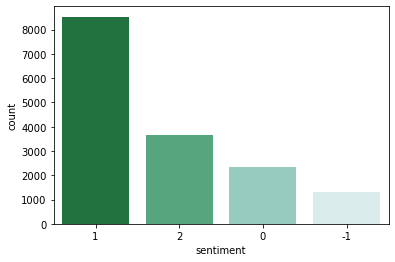

In [27]:
# Now, let's visually view number of message per sentiment type
ax = sns.countplot(
    x="sentiment",
    data=df,
    order=class_df.sentiment, # sorting the display of the sentiments so they appear in descending order
    palette='BuGn_r') # draw a countplot

Let's also plot a donut chart to know view percentage of tweets fall under each sentiment.

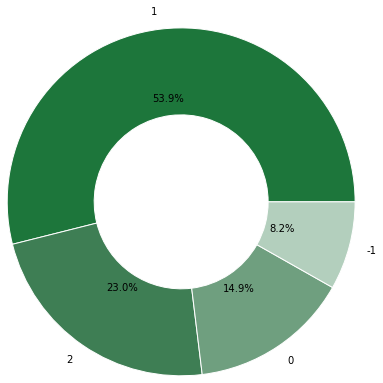

In [28]:
# A donut chart that shows the total percentage of tweet for each sentiment group
percent_class=class_df.message # we group the size of the sentiments in percentage
labels= class_df.sentiment

colors = ['#1d763b','#3e7e54','#6f9f7f','#b3cfbd'] # we use hex codes to select the preferred colors of each section

my_pie,_,_ = plt.pie(percent_class,radius = 2,labels=labels,colors=colors,autopct="%.1f%%") # here we set the size of the chart

plt.setp(my_pie, width=1, edgecolor='white') # set the color of the line that divides each section of the chart

plt.show() # displaying chart

This is quite interesting! We can see that the distribution of the ``sentiment`` types are highly imbalanced with:
- ``High Belief`` (1) sentiment has a total of 8530 messages, the largest portion
-  ``Moderate Belief`` (2) sentiment has a total of 3640 messagess
-  ``Neutral`` (0) sentiment has a total of 2353 messages
- ``Low Belief`` (-1) sentiment has a total of 1296 messages, the smallest portion

This implies that we need to resample to be able to achieve a balanced data set for training our models. This will make sure that the model predictions are not biased to *sentiments* with large portions of *messages*

### 4.3. Words and Character distribution


Seeing the percentage of tweets for each sentiment as shown above, we were then curious, as you should be, to know the number of characters used by users in tweets for each sentiment.
An histogram was used in making this graphical repesentation as shown below;

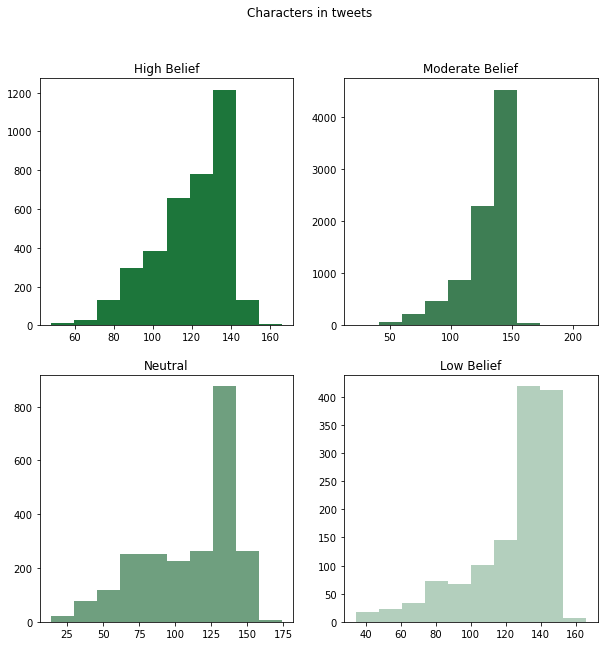

In [29]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10)) # we set the size of our graphs and make them 2x2

tweet_len=df[df['sentiment']==2]['message'].str.len()  # here we use the .str.len to find the total characters for each tweet
# in high belief

ax1.hist(tweet_len,color='#1d763b') # using hex codes to select color for graph 1

ax1.set_title('High Belief') # for sentiment 2, we name it High Belief

tweet_len=df[df['sentiment']==1]['message'].str.len() # here we use the .str.len to find the total characters for each tweet
# in moderate belief

ax2.hist(tweet_len,color='#3e7e54') # using hex codes to select color for graph 2

ax2.set_title('Moderate Belief') # for sentiment 1, we name it Moderate Belief

tweet_len=df[df['sentiment']==0]['message'].str.len()  # here we use the .str.len to find the total characters for each tweet
# in neutral

ax3.hist(tweet_len,color='#6f9f7f') # using hex codes to select color for graph 3

ax3.set_title('Neutral') # for sentiment 0, we name it neutral

tweet_len=df[df['sentiment']==-1]['message'].str.len() # here we use the .str.len to find the total characters for each tweet
# in low belief

ax4.hist(tweet_len,color='#b3cfbd') # using hex codes to select color for graph 4

ax4.set_title('Low Belief') # for sentiment -1, we name it Low Belief

fig.suptitle('Characters in tweets') # setting the overall plot title

plt.show() # display the graphs

Wow, that's a lot of characters used, seems people can't get their hands off their phones, so why don't we chaeck the amount of words used in tweets for each sentiment.
We'll represent this graphically using a histogram

Now to understand more about our messages, a distribution of the total number off words in each of our tweets. We will plot a histogram for this distribution for each of the sentiment categories

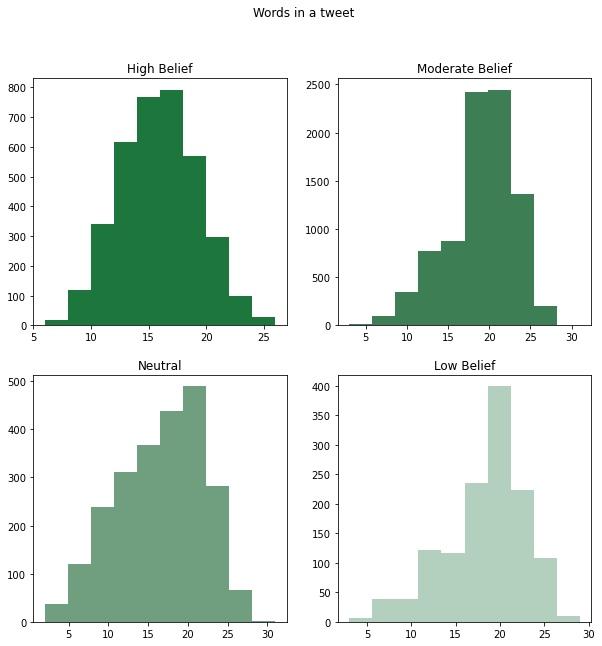

In [30]:
# Here we plot the total number of words in a tweet per sentiment
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10))

tweet_len=df[df['sentiment']==2]['message'].str.split().map(lambda x: len(x)) # using the split command and lambda function
# to sperate each word in the each tweet for high belief

ax1.hist(tweet_len,color='#1d763b') # using hex codes to select color for graph 1

ax1.set_title('High Belief') # setting the title for grapgh 1

tweet_len=df[df['sentiment']==1]['message'].str.split().map(lambda x: len(x))  # using the split command and lambda function
# to sperate each word in the each tweet for moderate belief

ax2.hist(tweet_len,color='#3e7e54') # using hex codes to select color for graph 2

ax2.set_title('Moderate Belief') # setting the title for grapgh 2

tweet_len=df[df['sentiment']==0]['message'].str.split().map(lambda x: len(x)) # using the split command and lambda function
# to sperate each word in the each tweet for neutral

ax3.hist(tweet_len,color='#6f9f7f') # using hex codes to select color for graph 3

ax3.set_title('Neutral') # setting the title for grapgh 3

tweet_len=df[df['sentiment']==-1]['message'].str.split().map(lambda x: len(x)) # using the split command and lambda function
# to sperate each word in the each tweet for low belief

ax4.hist(tweet_len,color='#b3cfbd') # using hex codes to select color for graph 4

ax4.set_title('Low Belief') # setting the title for grapgh 3

fig.suptitle('Words in a tweet') # setting the overall plot title

plt.show() # we set the size of our graphs and make them 2x2

Hmmmm, this looks interesting, now i wonder how many average words there could be for each tweet per sentiment, let's check that out shall we?

Text(0.5, 0.98, 'Average word length in each tweet')

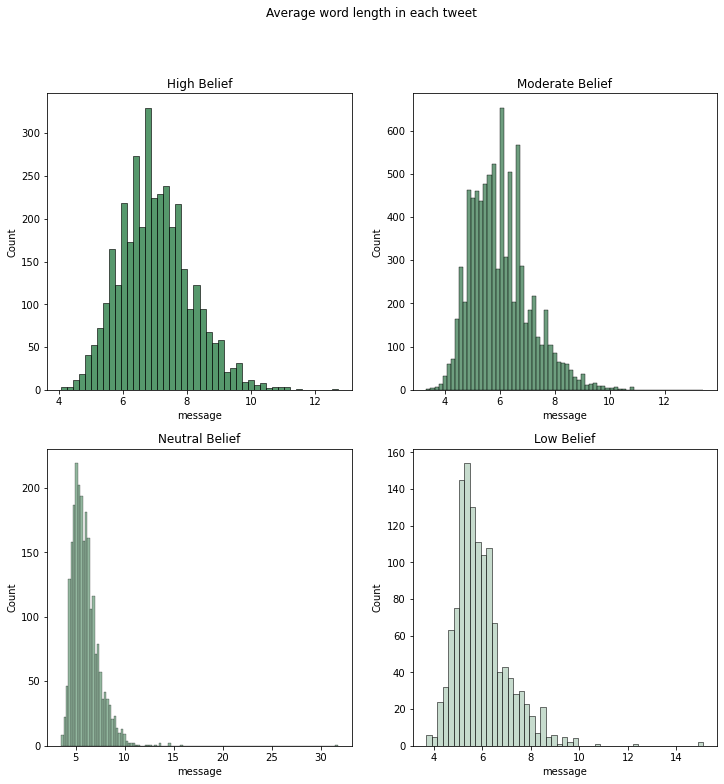

In [31]:
# Here we print the average tweet lenght per sentiment
fig,((ax1,ax2), (ax3,ax4))=plt.subplots(2,2,figsize=(12,12))

word=df[df['sentiment']==2]['message'].str.split().apply(lambda x : [len(i) for i in x]) # using the str.split to seprate each
# word in a tweet then use the lambda function to get the length

sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#1d763b') # using the np.mean to get the average of words lenght,
# and also using hex codes to set color

ax1.set_title('High Belief') # setting the title for grapgh 1

word=df[df['sentiment']==1]['message'].str.split().apply(lambda x : [len(i) for i in x])  # using the str.split to seprate each
# word in a tweet then use the lambda function to get the length

sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#3e7e54')  # using the np.mean to get the average of words lenght,
# and also using hex codes to set color

ax2.set_title('Moderate Belief') # setting the title for grapgh 2

word=df[df['sentiment']==0]['message'].str.split().apply(lambda x : [len(i) for i in x])  # using the str.split to seprate each
# word in a tweet then use the lambda function to get the length

sns.histplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#6f9f7f')  # using the np.mean to get the average of words lenght,
# and also using hex codes to set color

ax3.set_title('Neutral Belief') # setting the title for grapgh 3

word=df[df['sentiment']==-1]['message'].str.split().apply(lambda x : [len(i) for i in x])  # using the str.split to seprate each
# word in a tweet then use the lambda function to get the length

sns.histplot(word.map(lambda x: np.mean(x)),ax=ax4,color='#b3cfbd')  # using the np.mean to get the average of words lenght,
# and also using hex codes to set color

ax4.set_title('Low Belief') # setting the title for grapgh 4

fig.suptitle('Average word length in each tweet') # setting the overall plot title

Seeing the average word length above, we now have an understanding of our dataset and the meesages(tweets) by users and how they unfold
The next thing we can do is to find out the amount of words that hashtags for each sentiment.

### 4.4. Extracting Hashtags

We want to to create a function that extracts hashtags.
Then create a varible to save the hashtags extracts.
We then get the length of each hashtag for each sentiment and then use it to make a table which will be represented in a seasborn countplot.

In [32]:
# creating a function that extracts hashtags from tweets
def hashtag_extract(tweets):
    hashtags = [] # a list to put in the words that have hashtags beside them
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r'#(\w+)', tweet)
        hashtags.append(ht)
    return hashtags

In [33]:
# extract hashtags from tweets
# applying the function to each tweet sentiment, and assigning them to a variable
ht_high_belief = hashtag_extract(df['message'][df['sentiment']==2])

ht_moderate_belief = hashtag_extract(df['message'][df['sentiment']==1])

ht_neutral = hashtag_extract(df['message'][df['sentiment']==0])

ht_low_belief = hashtag_extract(df['message'][df['sentiment']==-1])

In [34]:
# geting the sum total of each word that has an hashtag beside them
ht_high_belief = sum(ht_high_belief, [])
ht_moderate_belief = sum(ht_moderate_belief, [])
ht_neutral = sum(ht_neutral, [])
ht_low_belief = sum(ht_low_belief, [])

In [40]:
# using freqdist to show a table  with the frequency of words for hastags that fall under high belief sentiment
freq = nltk.FreqDist(ht_high_belief)
d1 = pd.DataFrame({'Hashtag': list(freq.keys()),
                  'Count': list(freq.values())})
d1.head().style.background_gradient(cmap='summer')

,Hashtag,Count
0,climate,130
1,ClimateChange,12
2,CLIMATEchange,6
3,p2,14
4,skpol,1


In [42]:
# using freqdist to show a table  with the frequency of words for hastags that fall under moderate belief sentiment
freq = nltk.FreqDist(ht_moderate_belief)
d2 = pd.DataFrame({'Hashtag': list(freq.keys()),
                  'Count': list(freq.values())})
d2.head().style.background_gradient(cmap='summer')

,Hashtag,Count
0,TodayinMaker,1
1,ElectionNight,8
2,climatemarch,6
3,SaveOurPlanet,1
4,COP22,59


In [43]:
# using freqdist to show a table  with the frequency of words for hastags that fall under nuetral sentiment
freq = nltk.FreqDist(ht_neutral)
d3 = pd.DataFrame({'Hashtag': list(freq.keys()),
                  'Count': list(freq.values())})
d3.head().style.background_gradient(cmap='summer')

,Hashtag,Count
0,qanda,1
1,h,1
2,COAG,1
3,airquality,1
4,ClimateChange,4


In [44]:
# using freqdist to show a table  with the frequency of words for hastags that fall under low belief sentiment
freq = nltk.FreqDist(ht_low_belief)
d4 = pd.DataFrame({'Hashtag': list(freq.keys()),
                  'Count': list(freq.values())})
d4.head().style.background_gradient(cmap='summer')

,Hashtag,Count
0,NoMoreSCAMS,1
1,NoMoreDEMOCRATS,1
2,DrainTheSwamp,2
3,fakenews,3
4,myth,1


Representing the values of each table on a count plot

[Text(0.5, 1.0, 'Count Of Hashtags For High Belief')]

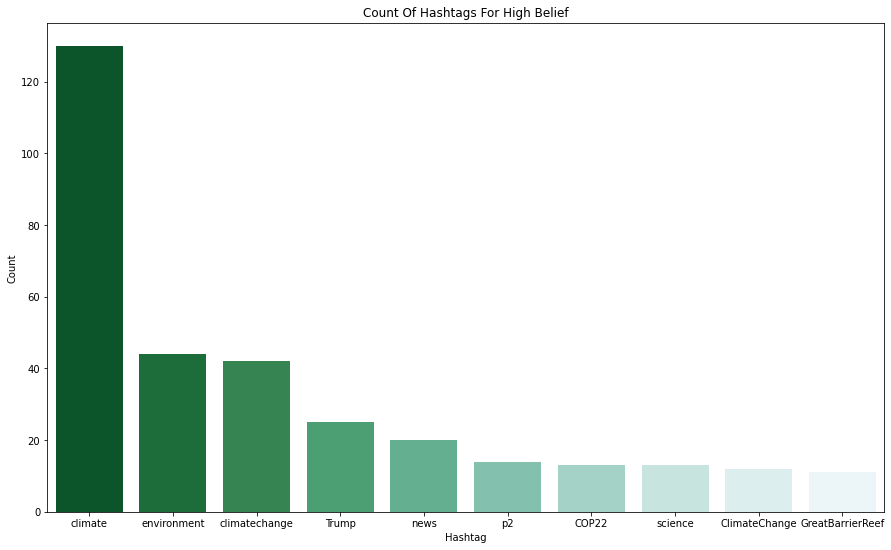

In [49]:
d1 = d1.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d1, x='Hashtag', y='Count',palette='BuGn_r').set(title='Count Of Hashtags For High Belief')

[Text(0.5, 1.0, 'Count Of Hashtags For Moderate Belief')]

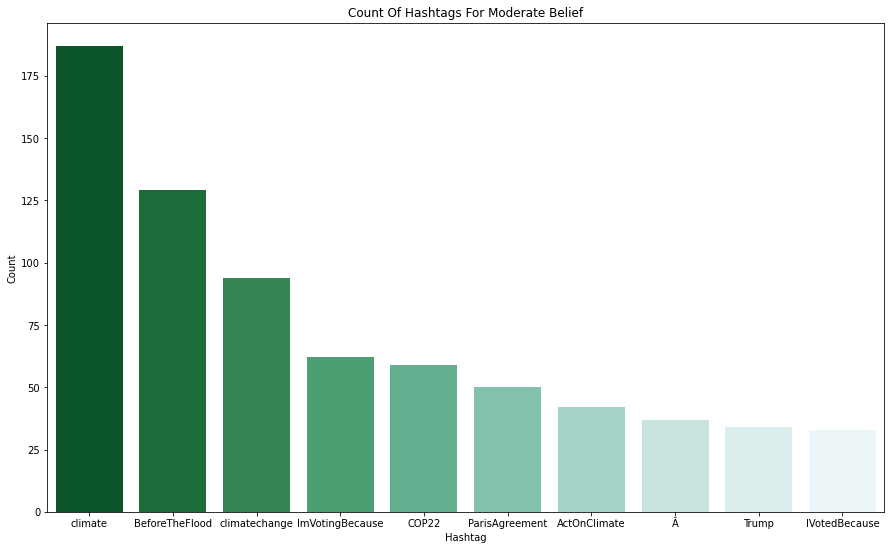

In [50]:
d2 = d2.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d2, x='Hashtag', y='Count',palette='BuGn_r').set(title='Count Of Hashtags For Moderate Belief')

[Text(0.5, 1.0, 'Count Of Hashtags For Neutral')]

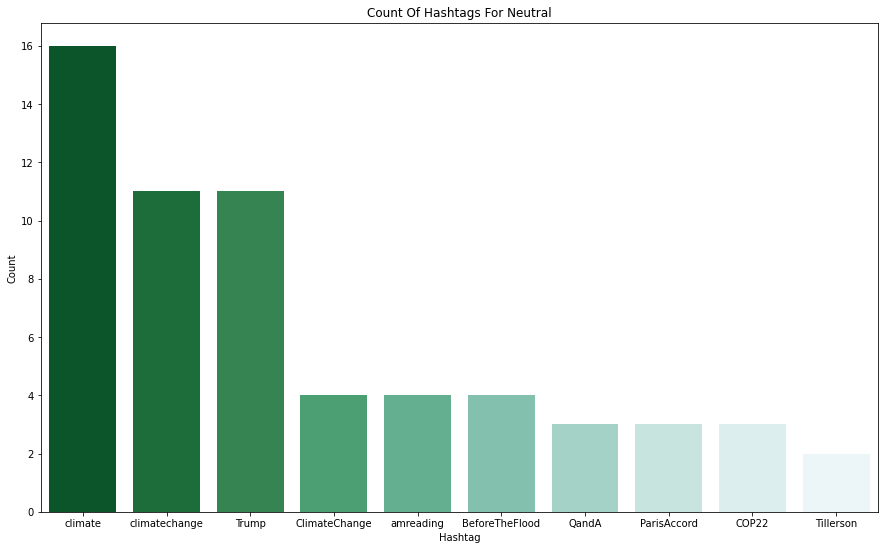

In [51]:
d3 = d3.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d3, x='Hashtag', y='Count',palette='BuGn_r').set(title='Count Of Hashtags For Neutral')

[Text(0.5, 1.0, 'Count Of Hashtags For Low Belief')]

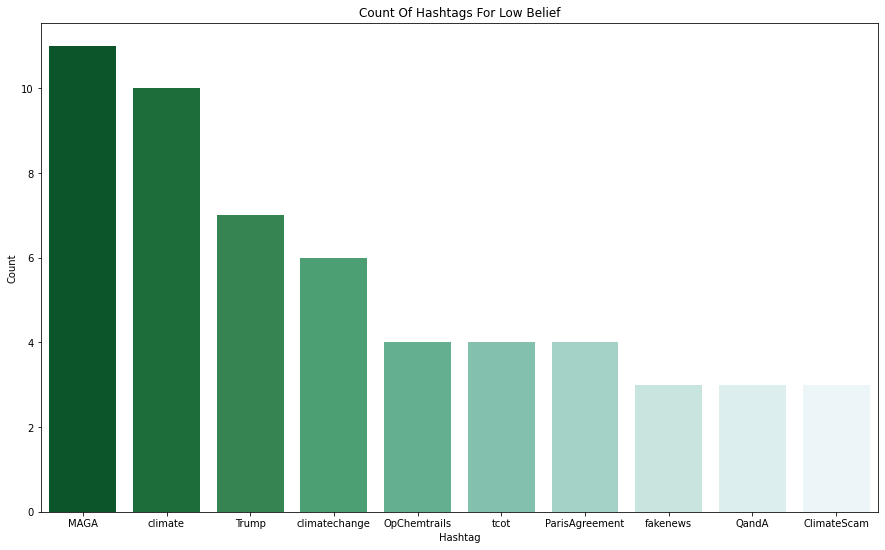

In [52]:
d4 = d4.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d4, x='Hashtag', y='Count',palette='BuGn_r').set(title='Count Of Hashtags For Low Belief')

## <font color='goldenrod'>5. Data Preprocessing</font>

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm.
Also, to remove learning bias from our models, we need to balance our data when we have an inbalanced classes in our dataset.
For NLP, the preprocessing steps are comprised of the following tasks:
- Tokenizing the string
- Lowercasing
- Removing stop words and punctuation
- Stemming

#### 5.1 Dealing with Imbalanced data

Since we have imbalanced data for our classes and we need the models to predict all the classes without any issue, we need to consider balancing it. While a slight imbalance wouldn’t be a problem, a highly imbalanced dataset like ours can cause issues to the classification predictions. And as most machine learning algorithms rely on sufficient data, the algorithm can’t correctly predict its result when some of the classes have little data.

Now, let's balance our data. With the ``Pro`` (1) has the largest proportion of **8530** we use that to set our sample size for each of the sentiment classes, say roughly about half.

In [ ]:
# Let's pick a class size of roughly half the size of the largest size
class_size = 5000
# Let's list the target labels
labels_counts = df['sentiment'].value_counts().to_dict() # create a dict with the setiment  as keys and counts as values

We, need to have now downsample the ``Pro`` (1) sentiment class while we upsample all the other sentiment classes by setting the ``replace`` attribute of skit learn's ``resample`` method to ``False`` and ``True`` respectively.

In [ ]:
resampled_classes = []

# For each label
for label, label_size in labels_counts.items():
    # If label_size < class size then set replace to True to upsample, else False to downsample
    if label_size < class_size:
        # Upsample
        replacement = True # sample with replacement (we need to duplicate observations)
    else:
        # Downsample
        replacement = False # sample with replacement (we need to duplicate observations)
    label_data = df[df['sentiment'] == label]
    label_resampled = resample(label_data,
                               replace=replacement, # sample without replacement (no need for duplicate observations)
                               n_samples=class_size, # number of desired samples
                               random_state=27) # reproducible results

    resampled_classes.append(label_resampled) # add to the resampled_classes list the sampled dataframe

Finally, let's concatenate all the resample dataframes to have a final balanced dataset to train our models on.

In [ ]:
resampled_data = pd.concat(resampled_classes, axis=0) # add the dataframes for the list together to have a final dataframe
print(resampled_data.shape) # view the dataframe

In [ ]:
# draw a bar graph to now show the final distribution classes of the resampled dataframe
ax = sns.countplot(x="sentiment", data=resampled_data, color='Orange', order=[1, 2, 0, -1])

Our datase now contains 20,000 tweets in total distributed 5,000 tweets four way making our classses have a balanced dataset.

#### 5.2 Remove hyperlinks, Twitter marks, and emojis

Let's explore some of tweets had see how they are composed to understand on how to now process the messages.

In [ ]:
tweetids_to_explore = df.loc[[625221, 698562, 573736, 911385, 483815], 'message'] # select a sample of the tweets
for m in tweetids_to_explore:
    print(m, end='\n\n')

From the five tweets we sampled, we can observe the following about our tweet messages.

- the beginning tweet **RT** that indicates one's re-posting someone else's content
- the official **@** and **#** character signifying handles and trends respectively
- the punctuations marks, emoticons, urls etc.

We need to do a lot of preprocessing to work have good clean data to work with.

First, let's creat a function to strip the emoticons from the tweets

In [ ]:
# function to strip emojis from the tweets
#Ref: https://www.kaggle.com/code/eliasdabbas/how-to-create-a-python-regex-to-extract-emoji/notebook
# Ref: https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1
# Ref: https://gist.github.com/Alex-Just/e86110836f3f93fe7932290526529cd1#gistcomment-3208085
# Ref: https://en.wikipedia.org/wiki/Unicode_block

def remove_emoji(text):
    EMOJI_PATTERN = re.compile(
        "(["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "])"
    )
    text = re.sub(EMOJI_PATTERN,  '', text)
    return text

Now, we need to create a function that actually handles the processing a tweet message, removing all emoticons, punctuation marks, tweet handles and trends, and removes english stopword.
We then create lemmas of the remaining words.

In [ ]:
def tweet_preprocessor(tweet):
    # remove the old style retweet text "RT"
    tweet_clean = re.sub(r'^RT[\s]+', '', tweet)

    # remove hashtags. We have to be careful here not to remove 
    # the whole hashtag because text of hashtags contains huge information. 
    # only remove the hash # sign from the word
    tweet_clean = re.sub(r'#', '', tweet_clean)

    # remove hyperlinks
    tweet_clean = re.sub(
        r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
        ,r'url-web',
        tweet_clean)

    # remove single numeric terms in the tweet. 
    tweet_clean = re.sub(r'\s[0-9]+\s', '', tweet_clean)

    # remove emojis from in the tweet
    tweet_clean = remove_emoji(tweet_clean)

    # remove punctuation from the tweet
    tweet_clean = ''.join([l for l in tweet_clean if l not in string.punctuation])

    # convert tweet to lowercase and return it
    tweet_clean = tweet_clean.lower()
    
    # tokenize the tweet
    tokenizer = TweetTokenizer() #Instantiate the tokenizer class
    tweet_tokens = tokenizer.tokenize(tweet_clean)
    
    # remove stop words
    stopwords_english = stopwords.words('english')
    tweet_tokens_without_stopwords = [t for t in tweet_tokens if t not in stopwords_english]
    
    # stem the tweet
    #stemmer = PorterStemmer()
    #tweet_stems = ' '.join([stemmer.stem(t) for t in tweet_tokens])
    
    # stem the tweet
    lemma = WordNetLemmatizer()
    tweet_stems = ' '.join([lemma.lemmatize(t) for t in tweet_tokens])
    
    return tweet_stems

 After creating our functions, we will need to to split the dataset into features and labels.

In [ ]:
#Get the features and targets
X = resampled_data['message']
y = resampled_data['sentiment']

The text documents in their original form can not be processed by the model classifiers and learning algorithms as most of them expect numerical feature vectors.

Rather than the raw text documents that have variable length, we will convert the ``message`` column to a bag of words vector using the skit learn's ``CountVectorizer`` to produce our features.
We will, specifically, calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf, for each term in the vectorized features using skit learn's ``TfidfTransformer``.

In [ ]:
vectorizer = CountVectorizer( # Instantiate the object
    preprocessor=tweet_preprocessor,
    min_df=2, # with min_df of 2 words in our bag of words
    max_df=0.5, # with max_df of 50% word frequency in our bag of words
    ngram_range=(1,2) # with ngram_range of (1,2) for bag of words
) 
vectorizer.fit(X) #build vocabulary for training
X_tokenized = vectorizer.transform(X) #encode the text data 

# scale the encoded text data 
tfidf_transformer = TfidfTransformer() # Instantiate the object
X_trans = tfidf_transformer.fit_transform(X_tokenized) # Transform the tokens
X_trans.shape

Now, each of the *20000* tweet messages is represented by *50602* features, representing the tf-idf score for different unigrams and bigrams.

## <font color='goldenrod'>6. Building the Models </font>

Now it is time to build our models.

For our of problem we are going to experiment with five different algorithms and explore their performance to find the performing best model.

Before we build the models, we are going to first split our features and labels into training and testing sets, create a list object containing our benchmark models and the hyper parameters that we will use to tune them (later), and lastly, we create functions to fit and evaluate the models.

Let's then split the features and labels to training and testing sets to have our ``X_train``, ``y_train`` , ``X_test`` and ``y_test``

In [ ]:
#Split the labels and target into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

Then instatiate our models in a list with the hyperparameters need for tuning them

In [ ]:
# Create a list containing the various models to evaluate
# include the parameters we are interested to tune for each model
models = [
    ## define the model Support Vector Classifier
    {  
        'model': SVC(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'C': [1, 10, 100],
            'gamma': [0.1,0.01,0.001],
            'kernel': ['rbf']
        }
    },
    ## define the model Random Forest Classifier
    {  
        'model': RandomForestClassifier(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'max_depth': [10, 20, 40, 50, 100, None],
            'n_estimators': [200, 400, 600, 800, 1000]
        }
    },
    ## define the model Logistic Regression Classifier
    {  
        'model': LogisticRegression(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'C' : [0.001, 0.01, 0.1, 1, 10, 100],
            'solver' : ['lbfgs', 'liblinear'],
            'max_iter' : [100, 1000, 2500]
        }
    },
    ## define the model KNeighbors Classifier
    { 
        'model': KNeighborsClassifier(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    },
    ## define the mode MultinomialNB Classifier
    {
        'model': MultinomialNB(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'alpha': [0.0001, 0.001, 0.1, 1, 10]
        }
    }    
]      

Finally, let's create functions to fit the models and evaluate them...

###### 1. function to fit the models

In [ ]:
# Function to fit the base models for on the data
# to view their initial performance
def fit_models(X_train, y_train, models):
    models_list = []
    for item in models:
        model = item['model']
        model.fit(X_train, y_train)
        models_list.append((model.__class__.__name__, model))
    return models_list

###### 2. function to evaluate the models

In [ ]:
# Function to predict targets for X_test
# and to return the accuracy and f1 scores, classification report, and confusion matrix
def evaluate_models(X_test, y_test, models):
    accuracy_scores = []
    f1_scores = []
    classification_reports = []
    confusion_matrices = []

    for (name, fitted_model) in fitted_models:
        y_pred = fitted_model.predict(X_test)
        accuracy_scores.append( # add to accuracy_scores the accuracy of model
            accuracy_score(y_test, y_pred) # find the accuracy
        )
        f1_scores.append( # add to f1_scores the f1 score of model
            f1_score(y_test, y_pred, average='weighted') # find the f1 score
        )
        classification_reports.append( # add to f1_scores the f1 score of model
            (name.upper(), classification_report(y_test, y_pred))
        )
        confusion_matrices.append(
            (name.upper(), confusion_matrix(y_test, y_pred))
        )
    return (accuracy_scores, f1_scores), (classification_reports, confusion_matrices)

Finally, having finished creating all those, let's proceed to training our models on the training data sets (``X_train``,``y_train``)

In [ ]:
# Fit the various model
fitted_models = fit_models(X_train, y_train, models)

In [ ]:
fitted_models # View the trained models

With our benchmark models trained, we need to evaluate their performance. We will use th skit learn's ``f1`` and ``accuracy`` scores to evaluate them.

In [ ]:
# Now we predict the target for the X_test for the models
# and get the accuracy and f1 scores
(accuracy_scores, f1_scores), _ = evaluate_models(X_test, y_test, fitted_models)

Let's view the scores of the models on the test dataset

In [ ]:
# let's create a Dataframe to tabulate the performance of various models
base_models_performance_df = pd.DataFrame(
    zip([i[0] for i in fitted_models], accuracy_scores, f1_scores),
    columns = ['model', 'accuracy', 'f1 score']
)
# and view the output as a table
base_models_performance_df

From the default models, we can observe that the SVC and Random Forest are the best (with the SVC having a slight edge), while alsothe Multinomial and Logistic coming in close. Only the Kneighbours has score that is far lower that the other four models.

## <font color='goldenrod'>7.  Tuning the Hyper Parameter of Models</font>

To finish the selection of our **best model**, we need to tune the models with the selected hyper parameter to see if we can get the best performing model. From these models we will then select the best scoring model with the best hyper parameters, using ``f1`` score.

To do this we will create a function that we will use to tune the models, before finally evaluate their performance on ``f1`` score.

In [ ]:
# Function to tune our base models
# and find the optimal params for each of our model 
# We use the f1 score as our scoring criteria
# and a cross-validation splitting (cv) of 10

def tuned_models(X_train, y_train, models):
    tuned_models = [] # initialise an empty list
    for item in models:
        model = item['model'] # get the model object instance
        param_grid = item['param_grid'] # get the parameters that will be used for tuning
        # define the grid instance
        grid =  GridSearchCV(
            model, # model instance
            param_grid = param_grid, # hyper-parameters
            cv = 10, # cross-validation splitting
            scoring = 'f1_weighted', # f1_scoring
            refit=True
        )
        print(f'Fitting {model.__class__.__name__} model....')
        grid.fit(X_train, y_train) # fit the grid to the X-train and the y_train
        tuned_models.append({ # add to tuned_models list the
            'name': model.__class__.__name__, # model name
            'tuned model': grid, # best model instance
            'best params': grid.best_params_, # best model parameters
            'f1 score': grid.best_score_, # best f1 score
            'refit time': grid.refit_time_ # the time the model took to refit the data
        })
        print(f'Finished fitting {grid.best_estimator_}')
        
    return tuned_models

Let's now tune our models

In [ ]:
# Tuning the models' parameters to produce the best model estimators
tuned_models = tuned_models(X_train, y_train, models)

In [ ]:
# let's create a Dataframe to tabulate best estimators and their performance
tuned_models_performance_df = pd.DataFrame(
    [(model['name'], model['best params'], model['f1 score'], model['refit time']) for model in tuned_models],
    columns = ['Model', 'Best Params', 'f1 Score', 'Refit Time'])
# and view the output as a table
tuned_models_performance_df

## <font color='goldenrod'>8. Evaluating our Model Performance</font>

For the tuned models, let's view the f1 score of each tuned model. We then will selected the model with the overall best *f1 score* as our model and as evaluate its classification performance.

Continue with our best model -------, we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_log)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Oranges')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

## KAGGLE SUBMISSION

In [ ]:
test_df = pd.read_csv('./data/test_with_no_labels.csv', index_col='tweetid')
test_df

In [ ]:
test_tokenized = vectorizer.transform(test_df['message'])

In [ ]:
test_trans = tfidf_transformer.fit_transform(test_tokenized)

In [ ]:
for (fitted_name, fitted_model) in fitted_models:
    test_pred = fitted_model.predict(test_trans)
    results_df = pd.DataFrame(test_pred.tolist(), index = test_df.index, columns=['sentiment'])
    results_df.to_csv(f"{fitted_name}_classification_predict.csv")

In [ ]:
for tuned_model in tuned_models:
    model_instance = tuned_model['tuned model']
    test_pred = model_instance.predict(test_trans)
    results_df = pd.DataFrame(test_pred.tolist(), index = test_df.index, columns=['sentiment'])
    results_df.to_csv(f"{tuned_model['name']}_classification_predict.csv")